In [2]:
from s3prl.downstream.mdd.dataset import L2ArcticDataset
from s3prl.downstream.augment_utils.add_noise import AddNoise
from IPython.display import Audio, display
from pathlib import Path
import torch
import torchaudio
import numpy as np

2024-04-08 17:44:32.699984: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-08 17:44:32.733492: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-08 17:44:33.390941: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
folder = Path('/home/xt0r3-user/cambridge/partii/dissertation/s3prl/data/rir/Audio')

wavs = []
srs = []

for path in folder.iterdir():
    if path.suffix != '.wav':
        continue
    wav, sr = torchaudio.load(path)
    wav = wav.squeeze()
    wav = wav / wav.norm()
    wavs.append(wav)
    srs.append(sr)
sr = srs[0]


In [4]:
wavs[0].shape

torch.Size([14950])

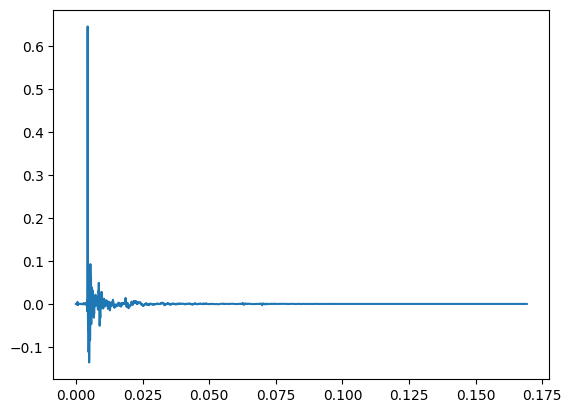

In [5]:
from matplotlib import pyplot as plt

def plot(wav):
    plt.plot(np.linspace(0, len(wav) / sr, wav.shape[-1]), wav)

plot(wavs[3])

In [6]:
Audio(wavs[150].flip(-1), rate=32000)

In [7]:
dataset = L2ArcticDataset(
    "train",
    "/home/xt0r3-user/cambridge/partii/dissertation/s3prl/data/l2arctic_release_v5.0",
    "/home/xt0r3-user/cambridge/partii/dissertation/s3prl/s3prl/s3prl/downstream/mdd/data/",
)

Skipping malformatted TextGrid file: /home/xt0r3-user/cambridge/partii/dissertation/s3prl/data/l2arctic_release_v5.0/YDCK/annotation/arctic_a0209.TextGrid
Skipping malformatted TextGrid file: /home/xt0r3-user/cambridge/partii/dissertation/s3prl/data/l2arctic_release_v5.0/YDCK/annotation/arctic_a0272.TextGrid


In [8]:
def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()
    display(Audio(waveform, rate=sample_rate))


audio = [
    torchaudio.functional.resample(dataset[0][0], orig_freq=44100, new_freq=16000),
    torchaudio.functional.resample(dataset[1][0], orig_freq=44100, new_freq=16000),
]

In [37]:
Audio(torchaudio.functional.fftconvolve(audio[0], wavs[30]), rate=16000)

In [10]:
wav, sr = torchaudio.load('reverb.wav')

display(sr)

# wav = torchaudio.functional.resample(wav, sr, 16000)

wav = wav / np.linalg.norm(wav)

16000

In [11]:
wav.shape

torch.Size([2, 4757])

In [12]:
Audio(torchaudio.functional.fftconvolve(audio[0], wav[0]), rate=16000)

In [13]:
Audio(audio[0], rate=16000)

In [14]:
sr

16000

In [19]:
def plot_rev(x):
    plot(torchaudio.functional.fftconvolve(audio[0], wavs[x]))

In [30]:
rng = torch.Generator()
rng.manual_seed(1337)
n = 5
indices = torch.randint(
    0,
    len(wavs),
    (n,),
    generator=rng,
)

fig, ax = plt.subplots(figsize=(10, 2 * n))

for i, idx in enumerate(indices):
    plt.plot(torchaudio.functional.fftconvolve(audio[0], wavs[idx]))
    plt.axis('off')
    plt.savefig(f"wav_{i}.png", bbox_inches='tight')
    plt.clf()

<Figure size 1000x1000 with 0 Axes>

In [32]:
fig, ax = plt.subplots(figsize=(15, 2))
plt.plot(audio[0], color='k')
plt.axis('off')
plt.savefig(f"wav.png", bbox_inches='tight')
plt.clf()

<Figure size 1500x200 with 0 Axes>

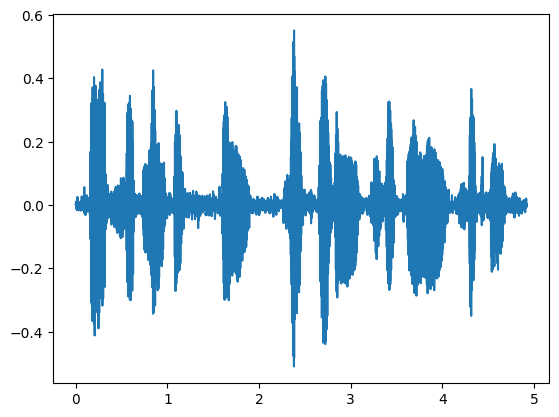

In [15]:
plot(audio[0])

In [16]:
display(Audio(wav, rate=sr))

In [17]:
play_audio(audio[0], 16000)

In [18]:
augmentation = AddNoise(
    prob=1.0,
    snr_low=0,
    snr_high=0.4,
    device="cpu",
    seed=1337,
)
audio = torch.nn.utils.rnn.pad_sequence(audio, batch_first=True)
lens = torch.tensor([len(audio[0]), len(audio[1])], dtype=torch.long)
aug_audio =     augmentation(
        audio,
        lens,
    )
play_audio(
    aug_audio[0],
    sample_rate=16000,
)

audio - aug_audio

tensor([[ 4.4652e-06, -9.7745e-06, -9.4897e-06,  ...,  7.3461e-05,
          1.4160e-05, -1.0848e-04],
        [ 8.9183e-05, -2.3929e-04, -1.1051e-03,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])